Mô phỏng hoạt động của mapreduce đối với linear regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification
import multiprocessing as mp
from collections import defaultdict
import time
import random

In [3]:
print("Thiết lập môi trường")
print(f"Số CPU có sẳn: {mp.cpu_count()}")

Thiết lập môi trường
Số CPU có sẳn: 2


Tạo tập dữ liệu

In [5]:
X_reg, y_reg = make_regression(n_samples = 1000, n_features=5, noise=0.1, random_state=41)
regression_data = list(zip(X_reg, y_reg))

Thiết lập lớp MapReduce

In [6]:
class MapReduce:
  def __init__(self, num_workers=None):
    self.num_workers = num_workers or mp.cpu_count()
  def map_reduce(self, data, mapper, reducer):
    #Bắt đầu bước map
    mapped_results = []

    chunk_size = len(data) // self.num_workers
    chunks = [data[i:i+chunk_size] for i in range (0, len(data), chunk_size)]

    with mp.Pool(self.num_workers) as pool:
      chunk_results = pool.map(mapper, chunks)
      for result in chunk_results:
        mapped_results.extend(result)

      shuffled = defaultdict(list)
      for key, value in mapped_results:
        shuffled[key].append(value)

      #Bắt đầu bước Reduce
      reduced_results = []
      key_chunks  = [list(shuffled.items())[i:i + chunk_size]
                     for i  in range(0,len(shuffled), chunk_size)]
      with mp.Pool(self.num_workers) as pool:
        reduce_chunk_results = pool.map(reducer, key_chunks)
        for result in reduce_chunk_results:
          reduced_results.extend(result)
      return dict(reduced_results)

    def sequential_map_reduce(self, data, mapper, reducer):
      mapped = []
      for item in data:
        mapped.extend(mapper([item]))
      shuffled = defaultdict(list)
      for key, value in mapped:
        shuffled[key].append(value)

      reduced= []
      for key, values in shuffled.items():
        reduced.append(reducer([(key, values)]))
      return dict([item for sublist in reduced for item in sublist])


Tạo một đối tượng MapReduce

In [7]:
mr = MapReduce(num_workers= 4)

Tạo một lớp MapReduceLinearRegression

In [12]:
class MapReduceLinearRegression:
  def __init__(self, learning_rate=0.01, max_iter=100):
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.weights = None
    self.bias = 0.0
    self.history = []
  def initialize_parameters(self, n_features):
    self.weights = np.random.normal(0, 0.1, n_features)
    self.bias = 0.0

  def predict(self, features):
    return np.dot(features, self.weights) + self.bias
  def mapper_linear_regression(self, data_chunk):
    gradients = []
    for features, target in data_chunk:
      prediction = self.predict(features)
      error = prediction - target

      grad_bias = error
      grad_weights = error * features

      gradients.append(('bias_grad', grad_bias))
      gradients.append(('weights_grad', grad_weights))
      gradients.append(('count', 1))
    return gradients

  def reducer_linear_regression(self, key_values_chunk):
    reduced = []
    for key, values in key_values_chunk:
      if key == 'bias_grad':
        total = np.sum(values)
        reduced.append(('bias_grad', total))
      elif key == 'weights_grad':
        total = np.sum(values, axis=0)
        reduced.append(('weights_grad', total))
      elif key == 'count':
        total = np.sum(values)
        reduced.append(('count', total))
    return reduced

  def compute_loss(self, data):
    total_error = 0.0
    for features, target in data:
      prediction = self.predict(features)
      error = (prediction - target) ** 2
      total_error += error
    return total_error / len(data)

  def train(self, data):
    n_features = len(data[0][0])
    self.initialize_parameters(n_features)

    for iteration in range(self.max_iter):
      gradients = mr.map_reduce(
          data,
          self.mapper_linear_regression,
          self.reducer_linear_regression)
      total_count = gradients['count']
      self.bias -=self.learning_rate * gradients['bias_grad'] / total_count
      self.weights -= self.learning_rate * gradients['weights_grad'] / total_count

      loss = self.compute_loss(data)
      self.history.append(loss)

      if iteration % 10 == 0:
        print(f'Iteration {iteration}: Loss = {loss:.4f}')

      if iteration > 10 and abs(self.history[-2] - self.history[-1]) < 1e-6:
        print(f'Quá trình học dừng ở {iteration + 1} iterration')
        break
    return self.history

Huấn luyện và dự đoán trên tập dữ liệu

Iteration 0: Loss = 15843.9461
Iteration 10: Loss = 15518.3494
Iteration 20: Loss = 15199.4510
Iteration 30: Loss = 14887.1128
Iteration 40: Loss = 14581.1999


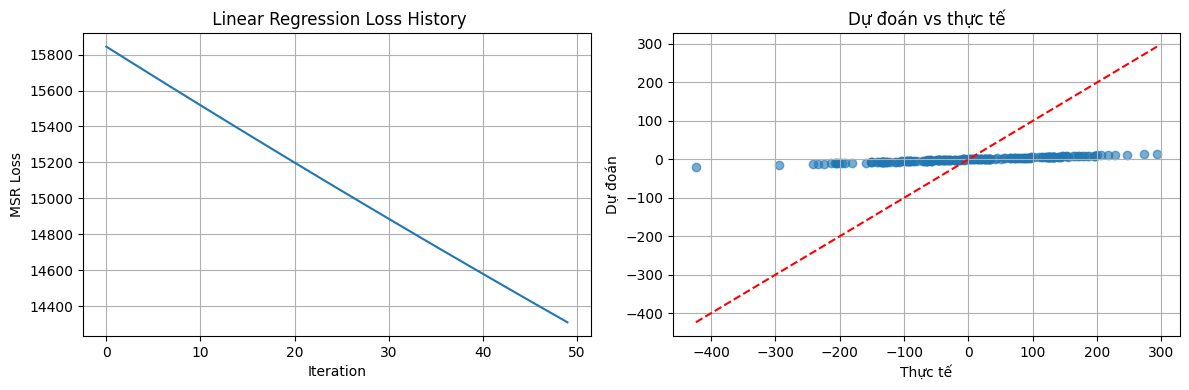

In [15]:
linear_model = MapReduceLinearRegression(learning_rate=0.001, max_iter=50)
loss_history = linear_model.train(regression_data[:800])

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title(' Linear Regression Loss History')
plt.xlabel('Iteration')
plt.ylabel('MSR Loss')
plt.grid(True)

test_predictions = [linear_model.predict(features) for features, _ in regression_data[800:]]
test_actual = [target for _,target in regression_data[800:]]

plt.subplot(1,2,2)
plt.scatter(test_actual, test_predictions, alpha=0.6)
plt.plot([min(test_actual), max(test_actual)], [min(test_actual), max(test_actual)], "r--")
plt.title('Dự đoán vs thực tế')
plt.xlabel('Thực tế')
plt.ylabel('Dự đoán')
plt.grid(True)

plt.tight_layout()
plt.show()


K-Means Iteration 0: Inertia = 3.7538
K-Means Iteration 10: Inertia = 3.7433
K-Means converged at iteration 13
Final centroids for K-Means:
[[-7.53751897 -7.25344155]
 [ 1.09680929  5.53496642]
 [-6.18340689 -6.3084334 ]]


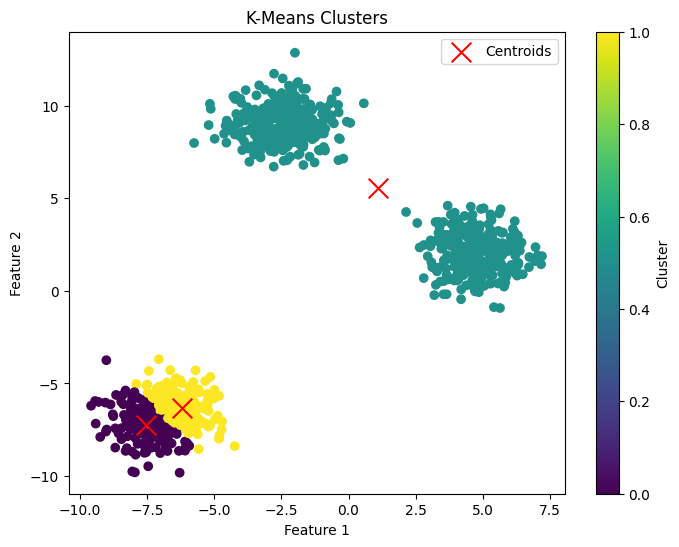

Scatter plot for K-Means clusters created.
KNN Accuracy: 1.0
Confusion Matrix for KNN:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


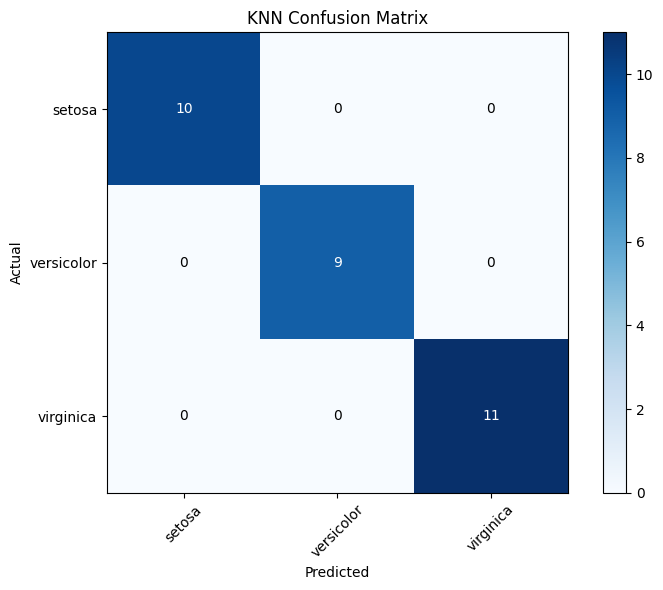

Confusion matrix plot for KNN created.


In [17]:
from sklearn.datasets import make_blobs, load_iris
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Tạo dữ liệu cho K-Means
X_km, y_km = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42, cluster_std=1.0)

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def mapper_kmeans(centroids, data_chunk):
    assignments = []
    k = len(centroids)
    for features in data_chunk:
        dist_to_centroids = [euclidean_distance(features, c) for c in centroids]
        cluster = np.argmin(dist_to_centroids)
        assignments.append((cluster, features))
    return assignments

def update_centroids(cluster_points, k, old_centroids):
    new_centroids = []
    for i in range(k):
        points = cluster_points.get(i, [])
        if points:
            new_centroids.append(np.mean(np.array(points), axis=0))
        else:
            new_centroids.append(old_centroids[i])
    return np.array(new_centroids)

def compute_inertia(centroids, data):
    total_dist = 0
    for features in data:
        dist_to_centroids = [euclidean_distance(features, c) for c in centroids]
        total_dist += min(dist_to_centroids)
    return total_dist / len(data)

class MapReduceKMeans:
    def __init__(self, k=3, max_iter=100, num_workers=4):
        self.k = k
        self.max_iter = max_iter
        self.num_workers = num_workers
        self.centroids = None
        self.history = []

    def train(self, data):
        # Initialize
        n_samples = len(data)
        idx = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = np.array([data[i] for i in idx])

        prev_inertia = float('inf')

        for iteration in range(self.max_iter):
            # Simulate Map (sequential)
            chunk_size = len(data) // self.num_workers
            chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

            mapper_partial = lambda chunk: mapper_kmeans(self.centroids, chunk)
            chunk_assign = [mapper_partial(chunk) for chunk in chunks]

            all_assignments = []
            for assign in chunk_assign:
                all_assignments.extend(assign)

            # Simulate Reduce
            cluster_points = defaultdict(list)
            for cluster, point in all_assignments:
                cluster_points[cluster].append(point)

            # Update
            new_centroids = update_centroids(cluster_points, self.k, self.centroids)

            # Inertia
            inertia = compute_inertia(new_centroids, data)
            self.history.append(inertia)

            if abs(prev_inertia - inertia) < 1e-6:
                print(f'K-Means converged at iteration {iteration}')
                break
            prev_inertia = inertia
            self.centroids = new_centroids

            if iteration % 10 == 0:
                print(f'K-Means Iteration {iteration}: Inertia = {inertia:.4f}')

        return self.history, self.centroids

# Chạy K-Means
kmeans_model = MapReduceKMeans(k=3, max_iter=50)
data_km = X_km.tolist()  # List of lists để tránh lỗi shape
history, final_centroids = kmeans_model.train(data_km)
print('Final centroids for K-Means:')
print(final_centroids)

# Thêm scatter plot cho K-Means
clusters = [np.argmin([euclidean_distance(x, c) for c in final_centroids]) for x in X_km]
plt.figure(figsize=(8,6))
plt.scatter(X_km[:,0], X_km[:,1], c=clusters, cmap='viridis')
plt.scatter(final_centroids[:,0], final_centroids[:,1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-Means Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()  # Hiển thị nếu chạy local
print('Scatter plot for K-Means clusters created.')

# KNN
def mapper_knn(train_chunk, test_point):
    neighbors = []
    for features, label in train_chunk:
        dist = euclidean_distance(test_point, features)
        neighbors.append((dist, label))
    return neighbors

def reducer_knn(neighbors_list, k):
    all_neighbors = []
    for neigh in neighbors_list:
        all_neighbors.extend(neigh)
    all_neighbors.sort(key=lambda x: x[0])
    top_k = all_neighbors[:k]
    labels = [label for _, label in top_k]
    prediction = np.bincount(labels).argmax()
    return prediction

class MapReduceKNN:
    def __init__(self, k=5, num_workers=4):
        self.k = k
        self.num_workers = num_workers

    def predict(self, X_test, train_data):
        predictions = []
        for test_point in X_test:
            # Simulate Map (sequential)
            chunk_size = len(train_data) // self.num_workers
            chunks = [train_data[i:i+chunk_size] for i in range(0, len(train_data), chunk_size)]

            chunk_neighbors = [mapper_knn(chunk, test_point) for chunk in chunks]

            # Reduce
            pred = reducer_knn(chunk_neighbors, self.k)
            predictions.append(pred)
        return np.array(predictions)

iris = load_iris()
X_knn = iris.data
y_knn = iris.target
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

knn_model = MapReduceKNN(k=5)
train_data = list(zip(X_train, y_train))
predictions = knn_model.predict(X_test, train_data)
acc = accuracy_score(y_test, predictions)
print('KNN Accuracy:', acc)

# Thêm confusion matrix cho KNN
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix for KNN:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=45)
plt.yticks(tick_marks, iris.target_names)
# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()  # Hiển thị nếu chạy local
print('Confusion matrix plot for KNN created.')